In [186]:
from zipfile import ZipFile

with ZipFile('images.zip', 'r') as zipObj: # <<<<<<<<<<<<<<<<<
     zipObj.extractall('images')

In [187]:
import os
from scipy.ndimage import convolve
from scipy.optimize import linear_sum_assignment
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import ndimage
from time import time
import math

Images = []
for im in os.listdir("images"):
  if "vector" in im:
    continue
  ima = np.array(Image.open("images/" + im))
  if ima.shape[0] == 176:
    Images.append(ima)

Images = np.array(Images)
np.random.shuffle(Images)

In [188]:
np.random.shuffle(Images)

In [189]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return ycbcr

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return rgb

In [190]:
def distance(image1, image2):
    im1 = image1.astype('float')
    im2 = image2.astype('float')
    im1 = rgb2ycbcr(im1)
    im2 = rgb2ycbcr(im2)

    return(np.mean((im1-im2)**2))

In [191]:
def get_matrix_shape(ratio, product_max, deviation = 10/100):
    best_distance = product_max**2+1
    product_min = max(1, int(product_max - product_max*deviation))
    for product in range(product_max, product_min, -1):
        for factor in range(1, product + 1):
            if not (product % factor):
                distance = (factor**2 * ratio - product)**2
                if distance < best_distance:
                    best_distance = distance
                    best_factor = factor
                    best_product = product
    print(f"The original ratio is {1/ratio:0.2f}")
    print(f"Is was rezise to a {best_factor**2/best_product:0.2f}")
    print(f"{product_max - best_product} images will be removed from the final picture")
    return best_product // best_factor, best_factor

The original ratio is 1.33
Is was rezise to a 1.36
16 images will be removed from the final picture


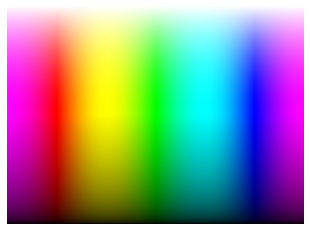

In [195]:
Model = Image.open('colors.png').convert('RGB') # <<<<<<<<<<<<<<<<<

height, length = get_matrix_shape(Model.size[1]/Model.size[0], len(Images))
h, l, c = Images[0].shape
Model = Model.resize((length * l, height * h))

plt.imshow(Model)
plt.axis(False)
plt.show()

In [198]:
Models = np.array(Model)
Models = Models.reshape((height, h, length * l, c)).swapaxes(1, 2)
Models = Models.reshape((height * length, h, l, c)).swapaxes(1, 2)

cost_matrix = [[distance(image, model) for image in Images] for model in Models]

model_idx, image_idx = linear_sum_assignment(cost_matrix)

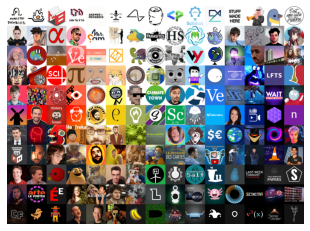

In [199]:
result = np.zeros((height*h, length*l, c)).astype('uint8')

for i in range(height):
  for j in range(length):
    result[h*i:h*(i+1), l*j:l*(j+1)] = Images[image_idx[length*i+j]]

plt.imshow(result)
plt.axis(False)

im = Image.fromarray(result)
im.save("Result_subs.jpeg")